In [19]:
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np
import unittest
from scipy.constants import mu_0
from discretize.tests import check_derivative
import discretize

from SimPEG.electromagnetics import natural_source as nsem
from SimPEG.electromagnetics.static import utils as sutils
from SimPEG import (
    maps, utils, optimization, inversion, inverse_problem, directives,
    data_misfit, regularization, data
)
from discretize import TensorMesh
from pymatsolver import Pardiso
import gmsh
from scipy.spatial import cKDTree
# import pyvista as pv

def get_surface_weights(mesh, actind, values, octree=False):
    """
        Function that determines the surface weights to be applied
        either an octree or tensor mesh
        input: discretize mesh object: mesh
               numpy array: active domain cells
               numpy array: value of weights at each cell
                            at depth determined by size of array
    """
    n_layer = values.size

    uniqXYlocs, topoCC = sutils.gettopoCC(mesh, actind, option='center')

    tree = cKDTree(mesh.gridCC)

    if octree:
        d, inds = tree.query(np.c_[uniqXYlocs, topoCC])

    else:
        d, inds = tree.query(np.c_[uniqXYlocs.gridCC, topoCC])

    # Regularization (just for mesh use)
    regmap = maps.IdentityMap(nP=int(actind.sum()))

    reg = regularization.Sparse(
        mesh, indActive=actind,
        mapping=regmap
    )

    surface_weights_temp = np.ones(mesh.nC)
    surface_weights_temp[inds] = values[0]
    surface_weights = surface_weights_temp.copy()

    if n_layer > 1:

        for i in range(n_layer - 1):
            temp = np.zeros(mesh.nC)

            temp[actind] = reg.regmesh.aveFy2CC * reg.regmesh.cellDiffyStencil * surface_weights_temp[actind]

            inds = temp == 0.5

            surface_weights[inds] = values[i + 1]

    return surface_weights




[INFO] creating Tensor Mesh...
[NOTE] Active cells are being generated
[NOTE] Active cells completed
230 (9760,)
6755 (9760,) (160, 2) (9760,)
[1.00000000e-01 1.83298071e-01 3.35981829e-01 6.15848211e-01
 1.12883789e+00 2.06913808e+00 3.79269019e+00 6.95192796e+00
 1.27427499e+01 2.33572147e+01 4.28133240e+01 7.84759970e+01
 1.43844989e+02 2.63665090e+02 4.83293024e+02 8.85866790e+02
 1.62377674e+03 2.97635144e+03 5.45559478e+03 1.00000000e+04] (35, 2)


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorNx has been deprecated, please use TensorMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discret

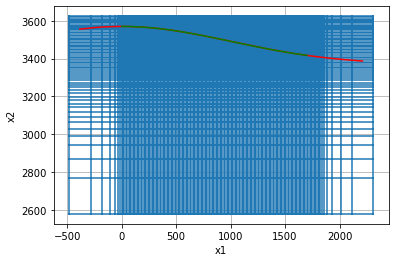

In [20]:
deriv_type = "sigma"
sim_type = "h"
fixed_boundary=True

    
print('[INFO] creating Tensor Mesh...')
mesh = discretize.TensorMesh(
[
    [(200,1),(100,1),(75,1),(50,1),(25,1),(20,1),(15,1),(12.5,146),(15,1),(20,1),(25,1),(50,1),(75,1),(100,1),(200,1)], #[(min cell size,left padding cells, growth factor),(min cell size, amount of cells @ that size),(min cell size,right padding cells, growth factor)]
    [(187.5,1),(100,1),(75,1),(50,1),(37.5,2),(25,3),(18.75,5),(12.5,5),(10,5),(8.75,10),(7.5,15),(6.25,12)]
], x0=[-485, 2580])

mesh.plotGrid()

b = 1000
A = 200

# create topography

Z = A * np.exp(-0.5 * ((mesh.vectorCCx / b) ** 2.0 )) + 3370

topo = np.vstack([mesh.vectorCCx, Z]).T


plt.plot(mesh.vectorCCx, Z, 'r')

print('[NOTE] Active cells are being generated')
actinds = utils.surface2ind_topo(mesh, topo, method='linear')       # active indicies
print('[NOTE] Active cells completed')


# create the synthetic model
sigma_back = 1e-3
sigma_right = 1e-1
sigma_porph = 1
sigma_basement = 1e-3
sigma_air = 1e-8

cells = mesh.cell_centers
sigma = np.ones(mesh.n_cells) * sigma_back
# Conductive sphere
x0 = 700
z0 = 3300
r0 = 100
csph = (
    np.sqrt(
        (mesh.gridCC[:, 0] - x0) ** 2.0
        + (mesh.gridCC[:, 1] - z0) ** 2.0
    )
) < r0
print(csph.sum(), csph.shape)
sigma[csph] = sigma_porph
sigma[cells[:, 1] <= 3200] = sigma_basement
sigma[~actinds] = sigma_air
# sigma = np.log(sigma)


print(actinds.sum(), actinds.shape, topo.shape, sigma.shape)

actmap = maps.InjectActiveCells(

    mesh, indActive=actinds, valInactive=np.log(1e-8)

)

if deriv_type == "sigma":
    sim_kwargs = {"sigmaMap": maps.ExpMap() * actmap}
    test_mod = np.log(sigma)
else:
    sim_kwargs = {"muMap": maps.ExpMap(), "sigma": sigma}
    test_mod = np.log(mu_0) * np.ones(mesh.n_cells)

frequencies = np.logspace(-1, 4, 20)

z_flight_height = A * np.exp(-0.5 * ((np.linspace(0, 1700, 35) / b) ** 2.0 )) + 3370


rx_locs = np.c_[np.linspace(0, 1700, 35), z_flight_height]

plt.plot(rx_locs[:, 0], rx_locs[:, 1], 'g')

print(frequencies, rx_locs.shape)


# if fixed_boundary:

#     actmap = maps.InjectActiveCells(

#         mesh, indActive=actinds, valInactive=np.log(1e-8)

#     )

#     # get field from 1D simulation
#     survey_1d = nsem.Survey(
#         [nsem.sources.Planewave([], frequency=f) for f in frequencies]
#     )
#     mesh_1d = TensorMesh([mesh.h[1]], [mesh.origin[1]])
#     sim_1d = nsem.simulation.Simulation1DMagneticField(
#         mesh_1d, survey=survey_1d, sigmaMap=maps.IdentityMap()
#     )

#     b_left, b_right, _, __ = mesh.cell_boundary_indices
#     f_left = sim_1d.fields(sigma[b_left])
#     f_right = sim_1d.fields(sigma[b_right])

#     b_e = mesh.boundary_edges
#     top = np.where(b_e[:, 1] == mesh.nodes_y[-1])
#     left = np.where(b_e[:, 0] == mesh.nodes_x[0])
#     right = np.where(b_e[:, 0] == mesh.nodes_x[-1])
#     e_bc = {}
#     for src in survey_1d.source_list:
#         e_bc_freq = np.zeros(mesh.boundary_edges.shape[0], dtype=np.complex)
#         e_bc_freq[top] = 1.0
#         e_bc_freq[right] = f_right[src, "e"][:, 0]
#         e_bc_freq[left] = f_left[src, "e"][:, 0]
#         e_bc[src.frequency] = e_bc_freq
#     sim_kwargs["e_bc"] = e_bc

rx_list = [
#     nsem.receivers.PointNaturalSource(
#         rx_locs, orientation="yx", component="real"
#     ),
#     nsem.receivers.PointNaturalSource(
#         rx_locs, orientation="yx", component="imag"
#     ),
#     nsem.receivers.Point3DTipper(
#         rx_locs, orientation="zx", component="imag"
#     ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase"
    ),
]

src_list = [nsem.sources.Planewave(rx_list, frequency=f) for f in frequencies]

survey = nsem.Survey(src_list)

sim = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey,
    **sim_kwargs,
    solver=Pardiso,
)

data_obs = sim.dpred(np.log(sigma[actinds]))

data_obs = data_obs + (np.random.randn(data_obs.shape[0]) * (data_obs * 0.05))
# print(np.random.randn(data_obs.shape[0]))

/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/mixins/mpl_mod.py:302: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


(9760,) 6755 (9760,) (160, 2) (9760,) 9760


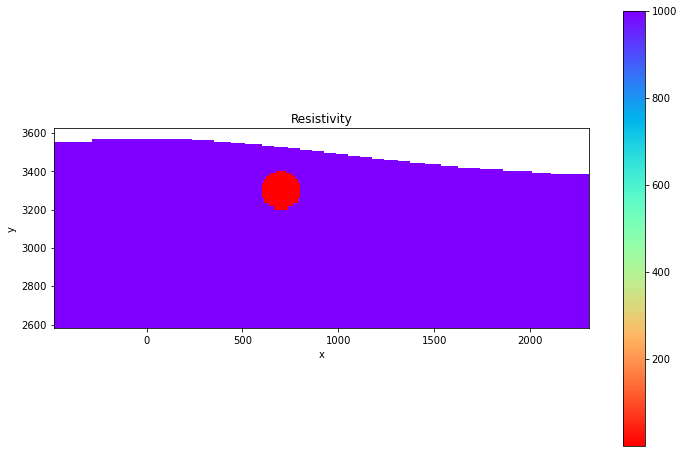

In [21]:
# ==========================================================================================
# Plot synthetic model

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mtrue = sigma  # np.ones(mesh.nC) * 1 / np.median(rho_app)                        # conductivity
mtrue[~actinds] = np.nan
clim = [0, 0.1]
print(mtrue.shape, actinds.sum(), actinds.shape, topo.shape, sigma.shape, mesh.nC)

dat = mesh.plot_image((1 / (mtrue)), ax=ax, grid=False,
#                      gridOpts={'alpha': 0.2},
                     pcolorOpts={"cmap": "rainbow_r"}
                    )
ax.set_title('Resistivity')
cb = plt.colorbar(dat[0], ax=ax)
# ax.set_xlim([-300, 4300])
# ax.set_ylim([-400, 0])
ax.set_aspect('equal')
# ax.plot(
#     survey_dc.electrode_locations[:, 0],
#     survey_dc.electrode_locations[:, 1], 'k.'
# )
plt.show()

# np.save('conductivity.npy', rho_est)

(20, 70)
0.011118322680110579


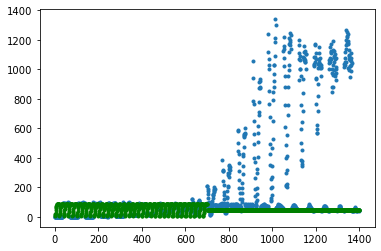

In [22]:
# assign error
data_rs = np.reshape(data_obs, (frequencies.shape[0], rx_locs.shape[0] * 2))
rs_error = np.zeros(data_rs.shape)
print(rs_error.shape)

# set some extended use variables
num_sites = rx_locs.shape[0]

eps = 1

eps = np.percentile(1 / data_rs[:, num_sites:], 10)
print(eps)
for ii in range(data_rs.shape[0]):
    
    
#     print(eps_i)
    std_r = 0.1
    std_i = 0.1
    
    rs_error[ii, :num_sites] = 1 / (np.abs(1 / data_rs[ii, :num_sites]) * std_r + eps)
    rs_error[ii, num_sites:] = np.abs(data_rs[ii, num_sites:]) * std_i + 40
    
#     plt.plot(rx_locs[:, 0], data_rs[num_sites:, ii], '-o')
#     plt.show()
    
std = rs_error.flatten('F')
# # print(std[:5], rs_error[:5, 0])

# eps = np.percentile(1 / data_obs, 10)
# print(np.percentile(1 / data_obs, 10))
# std = 1 / (abs((1 / data_obs) * 0.05) + eps)
# plt.loglog(frequencies, data_obs[:20], '.')
plt.plot(data_obs, '.')
# print(data_obs.shape)
plt.plot(std, '.g')

In [23]:
active_cells = actinds
#np.percentile(np.abs(data_obs), 10, interpolation='lower')
m0 = (np.ones(mesh.nC) * np.log(sigma_back))[actinds]
# m0[~actinds] = np.log(1e-8)
# std = abs(data_obs * 0.05) + eps
data_t = data.Data(survey, dobs=data_obs, standard_deviation=std)
# Clean sensitivity function formed with true resistivity
sim._Jmatrix = None

# Data Misfit
coolingFactor = 2
coolingRate = 1
beta0_ratio = 1e1
dmisfit = data_misfit.L2DataMisfit(data=data_t, simulation=sim)

# check for percentile floor

# print(uncert.shape)
dmisfit.W = 1. / std
# Map for a regularization
regmap = maps.IdentityMap(nP=int(actinds.sum()))
# reg = regularization.Tikhonov(mesh, indActive=actinds, mapping=regmap)
reg = regularization.Sparse(mesh, indActive=actinds, mapping=regmap)

# w_fac = np.asarray([25, 10, 5])


# surface_weights = get_surface_weights(mesh, active_cells, w_fac, octree=False)

# # Related to inversion
# reg.cell_weights = 1 / (mesh.vol[active_cells] * surface_weights[active_cells])

print('[INFO] Getting things started on inversion...')
# set alpha length scales
reg.alpha_s = 1
reg.alpha_x = 1
reg.alpha_y = 1
reg.alpha_z = 1
# plot uncertainties
# opt = Optimization.InexactGaussNewton(maxIter=6)
# opt = Optimization.GaussNewton(maxIter=15)
opt = optimization.ProjectedGNCG(maxIter=10, upper=np.inf, lower=-np.inf)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
beta = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=coolingRate
)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
target = directives.TargetMisfit()
target.target = survey.nD / 2.
saveIter = directives.SaveModelEveryIteration()
saveIterVar = directives.SaveOutputEveryIteration()

directiveList = [
    beta, betaest, target  # , saveIter, saveIterVar 
]

inv = inversion.BaseInversion(
    invProb, directiveList=directiveList)
# opt.LSshorten = 0.5
opt.remember('xc')

# Run Inversion ======================================================
minv = inv.run(m0)

[INFO] Getting things started on inversion...
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh._cellGradxStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh._cellGradyStencil has been deprecated, please use TensorMesh.stencil_cell_gradient_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.50e-03  1.62e+04  0.00e+00  1.62e+04    4.86e+02      0              
   1  3.75e-03  5.45e+03  2.04e+05  6.21e+03    1.07e+02      0              
   2  1.87e-03  2.19e+03  4.39e+05  3.01e+03    7.45e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.6205e+03
1 : |xc-x_last| = 3.0943e+01 <= tolX*(1+|x0|) = 5.6874e+01
0 : |proj(x-g)-x|    = 7.4483e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.4483e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      3
------------------------- DONE! -------------------------


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/mixins/mpl_mod.py:302: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


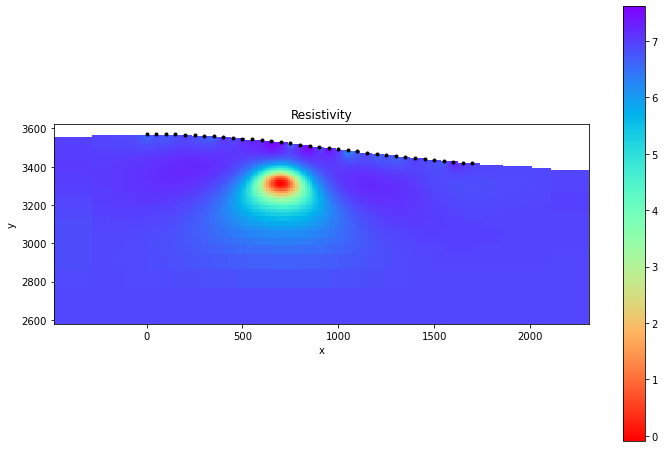

In [24]:
# ==========================================================================================
# Plot inversion results
rho_est = actmap * minv
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mtrue = 1 / np.exp(rho_est)  # np.ones(mesh.nC) * 1 / np.median(rho_app)                        # conductivity
mtrue[~actinds] = np.nan
clim = [0, 5]

dat = mesh.plotImage(np.log(mtrue), ax=ax, grid=False,
                     pcolorOpts={"cmap": "rainbow_r"}
                    )
ax.set_title('Resistivity')
cb = plt.colorbar(dat[0], ax=ax)
# ax.set_xlim([-300, 4300])
# ax.set_ylim([-400, 0])
ax.set_aspect('equal')
ax.plot(
    rx_locs[:, 0],
    rx_locs[:, 1], 'k.'
)
plt.show()

np.save('conductivity.npy', rho_est)

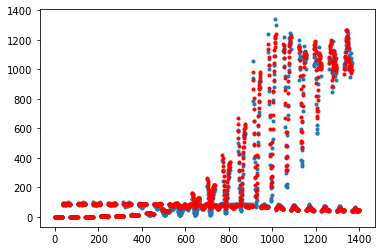

In [25]:
plt.plot(data_obs, '.')
plt.plot(invProb.dpred, '.r')

## PGI attempt
- Try PGI with the 2D MT problem

### Create the PGI parameters

In [52]:
# Compute the GMM parameters for each units
bckgdmean = -np.log(sigma_back)
bckgrdvar = 0.01
bckgrdprop = np.sum(mesh.vol[actinds][np.isclose(bckgdmean,mtrue[actinds])])/np.sum(mesh.vol[actinds])

resmean = -np.log(sigma_porph)
resvar = 0.01
resprop = np.sum(mesh.vol[actinds][np.isclose(resmean,mtrue[actinds])])/np.sum(mesh.vol[actinds])

values = sigma[actinds]
weights = mesh.vol[actinds]

# determine the mean and variance
cond_mean = np.average(values, weights=weights)

# Fast and numerically precise:
cond_variance = np.average((values - cond_mean)**2., weights=weights)

cond_prop = 1. -(bckgrdprop)

# ==================================================================

# Create the Prior GMM

#

gmmref = utils.WeightedGaussianMixture(
    
    n_components=2,
    mesh=mesh,
    actv=[actinds],
    covariance_type='full',
    max_iter=1000,
    n_init=1,
    reg_covar=4e-3,

)

gmmref.fit(sigma[actinds].reshape(-1, 1))

gmmref.means = np.c_[[-np.log(sigma_porph)], [cond_mean]][:,np.newaxis]

gmmref.covariances_ = np.array([[[0.01]],
                             [[cond_variance]],
                             ])

gmmref.compute_clusters_precisions()
                     
gmmref.weights_ = np.r_[bckgrdprop, cond_prop]

/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize-0.8.1-py3.9-linux-x86_64.egg/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vol has been deprecated, please use TensorMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/SimPEG-0.17.0-py3.9.egg/SimPEG/utils/pgi_utils.py:351: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.cell_volumes = self.mesh.cell_volumes[self.actv]


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/sklearn/mixture/_gaussian_mixture.py:758: RuntimeWarning: divide by zero encountered in log
  return np.log(self.weights_)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/sklearn/mixture/_gaussian_mixture.py:758: RuntimeWarning: divide by zero encountered in log
  return np.log(self.weights_)


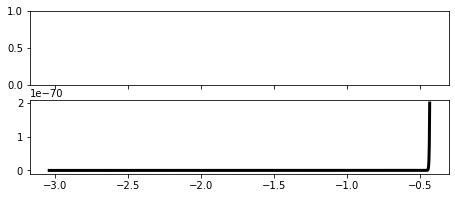

In [56]:
# plt.plot(weights, '.')
# plt.show()
# print(cond_variance, 1 / np.exp(cond_mean), actinds.sum())
import matplotlib.patheffects as pe
from matplotlib.ticker import StrMethodFormatter,FormatStrFormatter
# Plot the Prior GMM distribution
fig0, (ax, ax3) = plt.subplots(2, 1, sharex=True,figsize=(7.5,3))
fontsize=16
M = sim.mesh
testXplot = np.linspace(-7.,-1.,1000)[:,np.newaxis];
clfinv = gmmref
log_dens0 = gmmref.score_samples(testXplot);
log_dens = clfinv.score_samples(testXplot);
ax3.plot(np.log10(np.exp(testXplot)), np.exp(log_dens0),linewidth =3.,color='black',
         path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()]
        )

# ax3.set_xticks([-3,-2,-1])
# ax3.tick_params(labelsize=fontsize)
# ax3.xaxis.set_major_formatter(FormatStrFormatter('$10^{%.0f}$'))
# ax3.set_xlabel('Conductivity(S/m)',fontsize=fontsize)
# ax3.hist(np.log10(np.exp((mtrue))),density = True, bins = 20,color='k',ec='k', weights=mesh.vol);
# # ax3.set_ylim([0.,0.1])
# ax3.set_ylabel("Probability Density",fontsize=fontsize)

# ax.hist(np.log10(np.exp((mtrue))),density = True, bins = 20,color='k',ec='k', weights=mesh.vol/np.sum(mesh.vol));
# ax.tick_params(labelsize=fontsize)
# ax.plot(np.log10(np.exp(testXplot)), np.exp(log_dens0),linewidth =3.,color='black',
#          path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()]
#         )

# # ax.set_ylim([1.,4.])
# ax.set_yticks([1,2,3,4])
# ax.legend(['Prior Distribution','True Model\nWeighted Histogram','$m_0$ Hist'],loc=1,fontsize=fontsize)

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
# ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax3.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.show()

In [51]:
testXplot = np.linspace(-7.,-1.,1000)[:,np.newaxis];
print(testXplot.shape, 1 / np.exp(-1))

(1000, 1) 2.718281828459045


## Simplex meshes
- create a 2D version of the burried sphere simulation

In [3]:
# simplex mesh design

gmsh.initialize()

gmsh.clear()
gmsh.model.add("t3")


# add the points defining the mesh outline

# add lower points
lc = 100
gmsh.model.occ.addPoint(-500, 2600, 0, lc, 1)
gmsh.model.occ.addPoint(2210, 2600, 0, lc, 2)

# create the top points
gmsh.model.occ.addPoint(-500, 3650, 0, lc, 4)
gmsh.model.occ.addPoint(2210, 3650, 0, lc, 3)


lc = 12.5
gmsh.model.occ.addPoint(-500, topo[0, 1], 0, lc, 29)
cnt = 0
for ii in range(topo.shape[0]):

    if ii == 0:
        
        first = gmsh.model.occ.addPoint(topo[ii, 0], topo[ii, 1], 0, lc, ii + 30)
        first_pt = ii + 30
        
    else:
        
        if ii == topo.shape[0]-1:
            
            last = ii + 30
    
        gmsh.model.occ.addPoint(topo[ii, 0], topo[ii, 1], 0, lc, ii + 30)
    
    cnt += 1
    
    # create outterbox
gmsh.model.occ.addLine(1, first_pt - 1, 1000)
gmsh.model.occ.addLine(first_pt - 1, 4, 1001)
gmsh.model.occ.addLine(4, 3, 1002)
gmsh.model.occ.addLine(3, last, 1003)
gmsh.model.occ.addLine(last, 2, 1004)
gmsh.model.occ.addLine(2, 1, 1005)

surface = np.arange(29, ii + 31)
print(surface)
surface_list = surface.tolist()
p = gmsh.model.occ.addSpline(surface_list, 100)

gmsh.model.occ.addCurveLoop([1000, 1001, 1002, 1003, 1004, 1005], 1)
s = gmsh.model.occ.addPlaneSurface([1], 1111)
gmsh.model.occ.synchronize()

gmsh.model.mesh.embed(1, [p], 2, 1111)


# gmsh.model.occ.synchronize()
# gmsh.model.addPhysicalGroup(1, [1, 2, 4], 5)
# ps = gmsh.model.addPhysicalGroup(2, [1])
# gmsh.model.setPhysicalName(2, ps, "My surface")

# We can then generate a 2D mesh...
gmsh.model.mesh.generate(2)

# # ... and save it to disk
# gmsh.write("t1.vtk")

# Creates  graphical user interface
gmsh.fltk.run()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
[ 29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189]
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 100 (BSpline)
Info    : [ 20%] Meshing curve 1000 (Line)
Info    : [ 30%] Meshing curve 1001 (Line)
Info    : [ 50%] Meshing curve 1002 (Line)
Info    : [ 60%] Meshing curve 1003 (Line)
Info    : [ 80%] 

In [4]:
# Get node location and element index definitions from gmsh and create a discretize mesh
node_list, nodes, _ = gmsh.model.mesh.get_nodes()
el_type, elements, simps = gmsh.model.mesh.get_elements(dim=2)

nodes_r = nodes.reshape(3300, 3)
simps_r = (simps[0].reshape(-1, 3))-1

mesh = discretize.SimplexMesh(nodes_r[:, :2], simps_r)

3300.0


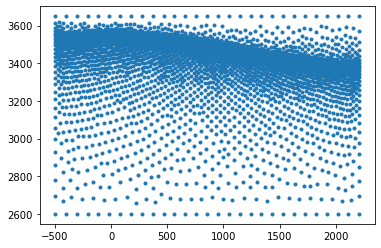

In [5]:
print(nodes.shape[0] / 3)
# print(nodes_r)
plt.plot(nodes_r[:, 0], nodes_r[:, 1], '.')

In [6]:
# The boundaries of the mesh align with the hemisphere.
sigma = np.full(mesh.n_cells, 0.01)

In [7]:
G = mesh.nodal_gradient
Me_sigma = mesh.get_edge_inner_product(sigma)
rhs = mesh.get_interpolation_matrix(rx_locs, location_type='nodes')
rhs = rhs.toarray()[0]

In [8]:
import scipy.sparse as sp
boundary_faces = mesh.boundary_faces
boundary_normals = mesh.boundary_face_outward_normals
n_bf = len(boundary_faces)

# Top gets 0 Nuemann
alpha = np.zeros(n_bf)

# # not top get Robin condition
# # assume a source point at the middle of the top of the mesh
# middle = np.median(mesh.nodes, axis=0)
# top_v = np.max(mesh.nodes[:, -1])
# source_point = np.r_[middle[:-1], top_v]

# # Others: Robin: alpha * phi + d phi dn = 0
# # where alpha = 1 / r  * r_hat_dot_n

# r_vec = boundary_faces - source_point
# r = np.linalg.norm(r_vec, axis=-1)
# r_hat = r_vec / r[:, None]
# r_dot_n = np.einsum("ij,ij->i", r_hat, boundary_normals)

# # Identify boundary faces on each side, and bottom
# min_x = boundary_faces[:, 0] == -2000
# min_y = boundary_faces[:, 1] == -2000
# min_z = boundary_faces[:, 2] == -2000
# max_x = boundary_faces[:, 0] == 2000
# max_y = boundary_faces[:, 1] == 2000
# not_top = min_x | min_y | min_z | max_x | max_y

# alpha[not_top] = (r_dot_n / r)[not_top]

P_bf = mesh.project_face_to_boundary_face

AvgN2Fb = P_bf @ mesh.average_node_to_face
AvgCC2Fb = P_bf @ mesh.average_cell_to_face

AvgCC2Fb = sp.diags(alpha * (P_bf @ mesh.face_areas)) @ AvgCC2Fb
AvgBC = AvgN2Fb.T @ AvgCC2Fb

A = G.T.tocsr() @ Me_sigma @ G + sp.diags(AvgBC @ sigma)

In [9]:
Ainv = Pardiso(A)

In [10]:
x = Ainv * rhs

In [14]:
print(x.shape, A.shape, n_bf)

(3300,) (3300, 3300) 109
